In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os
%matplotlib inline

# Turning Rate

We want to use the postion point to estimate turning rate. In order to do this, first we will use the curvature on the line formed by connecting the snout, center back, and tail base to determine if the mouse is turning. Then, if the mouse is turning, we calculate the turning rate from frame 1 to frame 2 - that is, we take the heading formed by the vector center-back-> snout and the heading formed by the next frame, take the dot product and normalize, which should give us a cos(theta), so we we take the inverse consine of that quantity, we then multiply by the framerate. 

## How can we find out if a certain three points indicate turning or not?

Let's calculate the regression line between the three points and then get the error when tested on the same line. If all three lines are colinear, this regression line will give zero error and error should correlate with amount of turning, at least with our assumptions. 

In [2]:
def sample_points_on_line(slope = 1, intercept = 0, num_samples = 3, noise_mean = 0, noise_std = .5):
    """
    Before we proceed, we first need a mechanism to test this, so we'll test samples.
    First, we will generate random points alone a line. Then, we need to add a noise factor
    """
    X = np.random.random(3) + np.random.normal(noise_mean, noise_std, num_samples)
    Y = slope * X + intercept + np.random.normal(noise_mean, noise_std, num_samples)
    return X, Y

In [3]:
X, Y = sample_points_on_line(noise_std = 0)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

In [4]:
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions

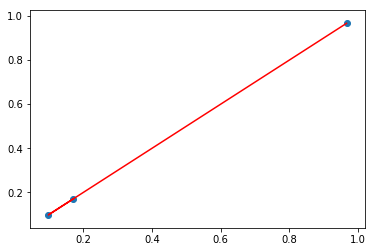

In [5]:

plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

In [6]:
mean_squared_error(Y, Y_pred)

0.0

Text(0.5, 1.0, 'The Influence of Noise on MSE')

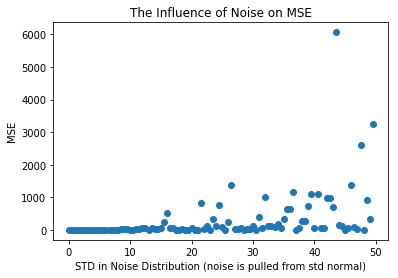

In [7]:

noises = []
errors = []
for i in range(100):
    X, Y = sample_points_on_line(noise_std = i/2)
    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1)
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    noises.append(i/2)
    errors.append(mean_squared_error(Y, Y_pred))

plt.scatter(noises, errors)
plt.xlabel('STD in Noise Distribution (noise is pulled from std normal)')
plt.ylabel('MSE')
plt.title('The Influence of Noise on MSE')

Noise actually has less of an influence on error than I thought! Regression is good at cutting through normal noise. This is a bit unrealistic though. Let's force the second point to be the midpoint of the other two

In [8]:
def sample_points_on_line_midpoint(slope = 1, intercept = 0, num_samples = 3, noise_mean = 0, noise_std = .5):
    """
    Before we proceed, we first need a mechanism to test this, so we'll test samples.
    First, we will generate random points alone a line. Then, we need to add a noise factor
    """
    X = np.random.random(3)
    X = np.sort(X)
    X[1] = (X[0] + X[2])/2
    X = X + np.random.normal(noise_mean, noise_std, num_samples)
    Y = slope * X + intercept + np.random.normal(noise_mean, noise_std, num_samples)
    return X, Y

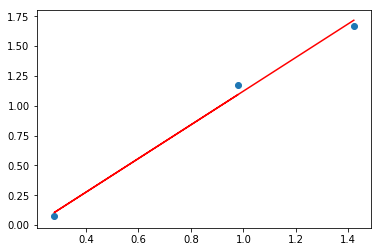

In [9]:
X, Y = sample_points_on_line_midpoint(noise_std = 0.5)
X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

## We have a method... now what?

So, we can now identify whether or not something is in a straight line... kind of. We want to be able to label point that we know are curves and points that we know are lines w/ noise very accurately. So, let's tkae some sample images from a video and do some testing. 

In [10]:
video_path = 'D:\Open field behavior\Test 520 - 9 mth - WT - NULL - 3047'
single_mouse_data_folder = 'D:\Open field behavior\plot-poses\Test 520 - 9 mth - WT - NULL - 3047'
outfolder = 'D:\Open field behavior\plot-poses\Test 520 - 9 mth - WT - NULL - 3047'
os.listdir(single_mouse_data_folder)

OSError: [WinError -2144272384] This drive is locked by BitLocker Drive Encryption. You must unlock this drive from Control Panel: 'D:\\Open field behavior\\plot-poses\\Test 520 - 9 mth - WT - NULL - 3047'

In [11]:
smoothed_snout = np.load(single_mouse_data_folder + '/kalman_filter_smoothing_plot_snout.npy')
smoothed_center_back = np.load(single_mouse_data_folder + '/kalman_filter_smoothing_plot_center_back.npy')
smoothed_tail_base = np.load(single_mouse_data_folder + '/kalman_filter_smoothing_plot_tail_base.npy')

OSError: [Errno 22] Invalid argument: 'D:\\Open field behavior\\plot-poses\\Test 520 - 9 mth - WT - NULL - 3047/kalman_filter_smoothing_plot_snout.npy'

In [12]:
pts_to_plt = 20

plt.scatter(smoothed_snout[:pts_to_plt, 0], smoothed_snout[:pts_to_plt, 2], label = 'Snout')
plt.scatter(smoothed_center_back[:pts_to_plt, 0], smoothed_center_back[:pts_to_plt, 2], label = 'Center Back')
#plt.scatter(smoothed_tail_base[:pts_to_plt, 0], smoothed_tail_base[:pts_to_plt, 2], label = 'Tail Base')
plt.legend()

NameError: name 'smoothed_snout' is not defined

In [13]:
cb_position = smoothed_center_back[2:3, [0,2]] # (x,y) of center back
snout_position = smoothed_snout[2:3, [0,2]] # (x,y) of snout
heading_1 = snout_position - cb_position 
cb_position = smoothed_center_back[3:4, [0,2]] # (x,y) of center back
snout_position = smoothed_snout[3:4, [0,2]] # (x,y) of snout

heading_2 = snout_position - cb_position
heading_1 = heading_1 / np.linalg.norm(heading_1)
heading_2 = heading_2 / np.linalg.norm(heading_2)
print(np.arccos(np.dot(heading_1.reshape(-1), heading_2.reshape(-1))) * 180/np.pi)
pts_to_plt = 2

plt.scatter(smoothed_snout[2:4, 1], smoothed_snout[2:4, 3], label = 'Snout')
plt.scatter(smoothed_center_back[2:4, 1], smoothed_center_back[2:4, 3], label = 'Center Back')
#plt.scatter(smoothed_tail_base[:pts_to_plt, 0], smoothed_tail_base[:pts_to_plt, 2], label = 'Tail Base')
plt.legend()

NameError: name 'smoothed_center_back' is not defined

In [14]:
degrees = []

for i in range(10000):
    cb_position = smoothed_center_back[i, [0,2]] # (x,y) of center back
    snout_position = smoothed_snout[i, [0,2]] # (x,y) of snout
    heading_1 = snout_position - cb_position 
    cb_position = smoothed_center_back[i+1, [0,2]] # (x,y) of center back
    snout_position = smoothed_snout[i+1, [0,2]] # (x,y) of snout
    heading_2 = snout_position - cb_position 
    heading_1 = heading_1 / np.linalg.norm(heading_1)
    heading_2 = heading_2 / np.linalg.norm(heading_2)
    degrees.append(np.arccos(np.dot(heading_1.reshape(-1), heading_2.reshape(-1))) * 180/np.pi)
    
plt.hist(degrees, 500)

NameError: name 'smoothed_center_back' is not defined

In [15]:
smoothed_snout_x = smoothed_snout[:,0]
smoothed_snout_y = smoothed_snout[:,2]
smoothed_cb_x = smoothed_center_back[:,0]
smoothed_cb_y = smoothed_center_back[:,2]
smoothed_tail_x = smoothed_tail_base[:,0]
smoothed_tail_y = smoothed_tail_base[:,2]

NameError: name 'smoothed_snout' is not defined

In [16]:
plot_poses = 'D:\Open field behavior\plot-poses\\'

In [17]:
os.listdir(plot_poses)

OSError: [WinError -2144272384] This drive is locked by BitLocker Drive Encryption. You must unlock this drive from Control Panel: 'D:\\Open field behavior\\plot-poses\\'

In [35]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
start = 0; end = 15
turn_rot = {'WT-NULL': {9: [], 18: []}, 'HET-NULL': {9: [], 18: []}, 'HET-ZFP': {9: [], 18: []}}

for folder in os.listdir(plot_poses):
    mouse_folder = folder
    if 'Test' not in folder:
        continue
    folder = plot_poses + folder
    smoothed_snout = np.load(folder + '/kalman_filter_smoothing_plot_snout.npy')
    smoothed_center_back = np.load(folder + '/kalman_filter_smoothing_plot_center_back.npy')
    smoothed_tail_base = np.load(folder + '/kalman_filter_smoothing_plot_tail_base.npy')
    
    smoothed_snout_x = smoothed_snout[:,0]
    smoothed_snout_y = smoothed_snout[:,2]
    smoothed_cb_x = smoothed_center_back[:,0]
    smoothed_cb_y = smoothed_center_back[:,2]
    smoothed_tail_x = smoothed_tail_base[:,0]
    smoothed_tail_y = smoothed_tail_base[:,2]
    
    
    control = mouse_folder.split('mth -')[1][:11].replace(' ', '')
    if control[-1] == '-':
        control = control[:-1]
    month = int(mouse_folder.split('mth')[0][-3:])
    fps = len(smoothed_snout_x) // (15*60)
    
    degrees = []
    for i in range(start*60*fps, end*60*fps):
        cb_position = smoothed_center_back[i, [0,2]] # (x,y) of center back
        snout_position = smoothed_snout[i, [0,2]] # (x,y) of snout
        heading_1 = snout_position - cb_position 
        cb_position = smoothed_center_back[i+1, [0,2]] # (x,y) of center back
        snout_position = smoothed_snout[i+1, [0,2]] # (x,y) of snout
        heading_2 = snout_position - cb_position 
        #heading_1 = heading_1 / np.linalg.norm(heading_1)
        #heading_2 = heading_2 / np.linalg.norm(heading_2)
        dot = np.dot(heading_1.reshape(-1), heading_2.reshape(-1))
        dot = dot / (np.linalg.norm(heading_1) * np.linalg.norm(heading_2))
        #dot = np.round(dot,2)
        rot = np.arccos(dot) * 180/np.pi * fps
        if np.isnan(rot):
            continue
        degrees.append(rot)
        turn_rot[control][month].append(rot)
    #turn_rot[control][month].append(np.average(degrees))

C:\Users\aar1105\.conda\envs\dlc\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in arccos


In [21]:
import pandas as pd
datasets = [turn_rot]
names = ["Average Turning Speed"]

time = str(start) + '-' + str(end)
for idx in range(len(datasets)):
    dict_to_df = {'Genotype': [], 'Metric': []}
    dic = datasets[idx]
    print(names[idx])
    for key in dic: 
        
        for key2 in dic[key]:
            geno = key + ": " + str(key2) + " Month"
            for dat in dic[key][key2]:
                dict_to_df['Genotype'].append(geno)
                dict_to_df['Metric'].append(dat)
    df = pd.DataFrame.from_dict(dict_to_df)
    print(plot_poses + 'final_csv\\' + names[idx] + "_" + time + ".csv")
    df.to_csv(plot_poses + 'final_csv\\' + names[idx] + "_" + time + ".csv")

Average Turning Speed
D:\Open field behavior\plot-poses\final_csv\Average Turning Speed_0-15.csv


In [36]:
datasets = [turn_rot]
human_readable_names  = ["Turning Speed"]
names = ["turn_speed"]
units = ["degrees/second"]
time = str(start) + '-' + str(end)
for idx in tqdm(range(len(datasets))):
    current_file = open(plot_poses + 'final_csv/' + names[idx] + "_" + time + "summary_stats.txt", 'w+')
    curr_dict = datasets[idx]
    current_file.write(human_readable_names[idx] + '\n')
    current_file.write("All values for this sample are given in " + units[idx] + '\n')
    for k1 in curr_dict:
        for k2 in curr_dict[k1]:
            current_file.write("=========================================================" + '\n')
            current_file.write(str(k1) + " - " + str(k2) + " Month "+ '\n')
            current_file.write('Number of Samples: ' + str(len(curr_dict[k1][k2]))+ '\n')
            current_file.write('\n')
            current_file.write("10" + ": " + str(np.percentile(curr_dict[k1][k2], 10))+ '\n')
            current_file.write("25" + ": " + str(np.percentile(curr_dict[k1][k2], 25))+ '\n')
            current_file.write("50" + " (Median):" + str(np.median(curr_dict[k1][k2]))+ '\n')
            current_file.write("75" + ": " + str(np.percentile(curr_dict[k1][k2], 75))+ '\n')
            current_file.write("90" + ": " + str(np.percentile(curr_dict[k1][k2], 90))+ '\n')
                
    current_file.close()       


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


In [24]:
from tqdm import tqdm

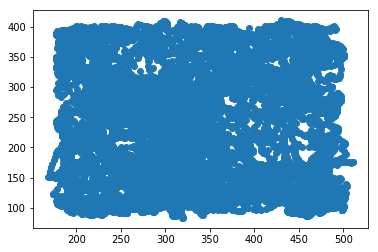

In [23]:
plot_poses = 'D:\Open field behavior\plot-poses\Test 520 - 9 mth - WT - NULL - 3047\\'
cb = np.load(plot_poses + 'kalman_filter_smoothing_plot_center_back.npy')
tail_base = np.load(plot_poses + 'kalman_filter_smoothing_plot_tail_base.npy')
snout = np.load(plot_poses + 'kalman_filter_smoothing_plot_snout.npy')

plt.scatter(snout[:, 0], snout[:, 2])

In [47]:
from sklearn.metrics import mean_absolute_error
error = []
for idx in range(cb.shape[0]):
    cb_x = cb[idx, 0]
    cb_y = cb[idx, 2]
    snout_x = snout[idx, 0]
    snout_y = snout[idx, 2]
    tb_x = tail_base[idx, 0]
    tb_y = tail_base[idx, 2]
    X = np.array([snout_x, cb_x, tb_x]).reshape(-1, 1)
    Y = np.array([snout_y, cb_y, tb_y]).reshape(-1, 1)
    
    linear_regressor = LinearRegression()  # create object for the class
    linear_regressor.fit(X, Y)  # perform linear regression
    Y_pred = linear_regressor.predict(X)  # make predictions
    #plt.scatter(X, Y)
    #plt.plot(X, Y_pred, color='red')
    error.append(mean_absolute_error(Y, Y_pred))
    #plt.show()


1.5832720305724477


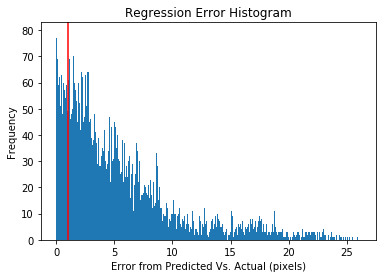

3650


In [60]:
plt.hist(error, 1000)
axes = plt.gca()
#axes.set_xlim([0,1])
#axes.set_ylim([0,500])
cutoff = np.mean(error) - .75*np.std(error)
print(cutoff)
plt.axvline(x=1, color = 'r', label = '1 Pixel Error Cutoff')
plt.xlabel('Error from Predicted Vs. Actual (pixels)')
plt.ylabel('Frequency')
plt.title('Regression Error Histogram')
plt.savefig('reg_error_hist.pdf')
plt.show()
print(len([i for i in error if i < cutoff]))

In [55]:

len([i for i in error if i < cutoff])

3650

In [53]:
len(error)

15471

In [83]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline
start = 0; end = 2
turn_rot = {'WT-NULL': {9: [], 18: []}, 'HET-NULL': {9: [], 18: []}, 'HET-ZFP': {9: [], 18: []}}
plot_poses = 'D:\Open field behavior\plot-poses\\'

for folder in tqdm(os.listdir(plot_poses)):
    mouse_folder = folder
    if 'Test' not in folder:
        continue
    folder = plot_poses + folder
    smoothed_snout = np.load(folder + '/kalman_filter_smoothing_plot_snout.npy')
    smoothed_center_back = np.load(folder + '/kalman_filter_smoothing_plot_center_back.npy')
    smoothed_tail_base = np.load(folder + '/kalman_filter_smoothing_plot_tail_base.npy')
    
    smoothed_snout_x = smoothed_snout[:,0]
    smoothed_snout_y = smoothed_snout[:,2]
    smoothed_cb_x = smoothed_center_back[:,0]
    smoothed_cb_y = smoothed_center_back[:,2]
    smoothed_tail_x = smoothed_tail_base[:,0]
    smoothed_tail_y = smoothed_tail_base[:,2]
    
    
    control = mouse_folder.split('mth -')[1][:11].replace(' ', '')
    if control[-1] == '-':
        control = control[:-1]
    month = int(mouse_folder.split('mth')[0][-3:])
    fps = len(smoothed_snout_x) // (15*60)
    
    degrees = []
    for i in range(start*60*fps, end*60*fps):
        cb_position = smoothed_center_back[i, [0,2]] # (x,y) of center back
        snout_position = smoothed_snout[i, [0,2]] # (x,y) of snout
        tb_position = smoothed_tail_base[i, [0,2]] 
        
        X = np.array([snout_position[0], cb_position[0], tb_position[0]]).reshape(-1, 1)
        Y = np.array([snout_position[1], cb_position[1], tb_position[1]]).reshape(-1, 1)
        
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(X, Y)  # perform linear regression
        Y_pred = linear_regressor.predict(X)  # make predictions
        
        if mean_absolute_error(Y, Y_pred) < 2.5:
            continue
        
        heading_1 = snout_position - cb_position 
        cb_position = smoothed_center_back[i+1, [0,2]] # (x,y) of center back
        snout_position = smoothed_snout[i+1, [0,2]] # (x,y) of snout
        heading_2 = snout_position - cb_position 
        #heading_1 = heading_1 / np.linalg.norm(heading_1)
        #heading_2 = heading_2 / np.linalg.norm(heading_2)
        dot = np.dot(heading_1.reshape(-1), heading_2.reshape(-1))
        dot = dot / (np.linalg.norm(heading_1) * np.linalg.norm(heading_2))
        #dot = np.round(dot,2)
        rot = np.arccos(dot) * 180/np.pi * fps
        if np.isnan(rot):
            continue
        degrees.append(rot)
        #turn_rot[control][month].append(rot)
    turn_rot[control][month].append(np.average(degrees))

100%|████████████████████████████████████████████████████████████████████████████████| 102/102 [01:15<00:00,  1.35it/s]


In [84]:
import pandas as pd
datasets = [turn_rot]
names = ["Average Turning Speed"]

time = str(start) + '-' + str(end)
for idx in range(len(datasets)):
    dict_to_df = {'Genotype': [], 'Metric': []}
    dic = datasets[idx]
    print(names[idx])
    for key in dic: 
        
        for key2 in dic[key]:
            geno = key + ": " + str(key2) + " Month"
            for dat in dic[key][key2]:
                dict_to_df['Genotype'].append(geno)
                dict_to_df['Metric'].append(dat)
    df = pd.DataFrame.from_dict(dict_to_df)
    print(plot_poses + 'final_csv\\' + names[idx] + "_" + time + ".csv")
    df.to_csv(plot_poses + 'final_csv\\' + names[idx] + "_" + time + ".csv")

Average Turning Speed
D:\Open field behavior\plot-poses\final_csv\Average Turning Speed_0-2.csv


In [177]:
import random
import math
import numpy as np

class PositionGenerator:
    def __init__(self, arena: str = 'circle', size: int = 100, mean_turning: float = 25, \
                 turning_noise: float = 1, proportion_in_center: float = .35, center_noise: float = .1, fps: int  = 30, max_speed: float = 45) -> None:
        """
        Arena can only be circle or square, size is radius if circle, side length if square
        """
        self.arena = arena
        self.size = 100
        if arena == 'circle':
            # radius of the circle
            circle_r = size
            # center of the circle (x, y)
            circle_x = 0
            circle_y = 0

            # random angle
            alpha = 2 * math.pi * random.random()
            # random radius
            r = circle_r * math.sqrt(random.random())
            # calculating coordinates
            x = r * math.cos(alpha) + circle_x
            y = r * math.sin(alpha) + circle_y
            self.center_back = (x, y)
            print("Initial Center Back", (x, y))
        choices = [1, -1]
        first = random.choice(choices)
        second = random.choice(choices)
        self.snout = (x + 5 *first, y + 5 * second)
        self.turning_rate_mean = mean_turning                 # degrees per second, needs to be converted to degrees per frame
        self.turning_rate_std = turning_noise                 # degrees per second, needs to be converted to degrees per frame
        
        self.proportion_in_center = proportion_in_center      # seconds
        self.proportion_in_center = center_noise              # seconds
        self.fps = fps                                        # frames/second
        self.max_speed = max_speed                            #cm/second -> need to convert to cm/frame
        
        
    def __iter__(self):
        return self
    
    
    def __next__(self):
        current_turn = np.random.normal(self.turning_rate_mean, 75)
        current_turn = current_turn/self.fps
        #current_turn = 90
        #current_turn = np.random.uniform(0,90)
        current_speed = np.random.uniform(0, self.max_speed)
        current_speed = current_speed/self.fps
        #print('Current Turn is {} and current Speed is {}'.format(current_turn, current_speed))
        
        self.snout = (newX, newY)
        #self.tail_base = (self.center_back[0] + delta_x, self.center_back[1] + delta_y)
        #if np.linalg.norm(np.array(self.snout)) > self.size:
        #    self.snout = (self.snout[0] - 2* delta_x, self.snout[1] - 2*delta_y)
        #    self.tail_base = (self.center_back[0] - 2*delta_x, self.center_back[1] - 2*delta_y)

        return newX, newY        

Initial Center Back (34.84267522595748, 21.5360935429284)


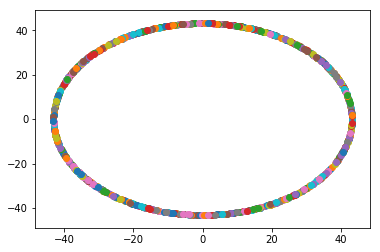

In [175]:
test = PositionGenerator(arena = 'circle', size = 100, mean_turning = 25)

snout_positions = []
i = 0
for t in test:
    plt.scatter(t[0], t[1])
    if i > 1000:
        break
    i += 1

In [178]:
np.random.normal(25,1)

25.50863268395492

In [179]:
from scipy.optimize import minimize, rosen, rosen_der

In [219]:
def opt(A: np.array, theta):
    def to_opt(x):
        #A = A/np.linalg.norm(A)
        x,y = x
        f1 = (np.linalg.norm(A-np.array((x,y))) - np.cos(theta))**2
        f2 = (np.linalg.norm(np.array([x,y])) - 1)**2
        return f1 + f2
    return to_opt

    

In [225]:
test = opt(np.array([1,2])/np.linalg.norm(np.array([1,2])), 15)

In [228]:
from scipy.optimize import minimize
res = minimize(test, [0,1], method='SLSQP', tol=1e-6)

In [229]:
test(res.x)

0.5771281249915045

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:51<00:00, 192.57it/s]


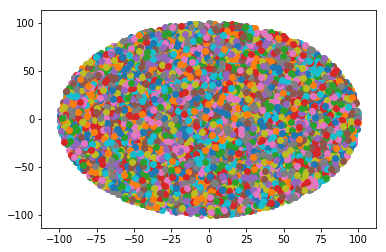

In [90]:
import random
import math
from tqdm import tqdm
# radius of the circle
circle_r = 100
# center of the circle (x, y)
circle_x = 0
circle_y = 0
for i in tqdm(range(10000)):
    # random angle
    alpha = 2 * math.pi * random.random()
    # random radius
    r = circle_r * math.sqrt(random.random())
    # calculating coordinates
    x = r * math.cos(alpha) + circle_x
    y = r * math.sin(alpha) + circle_y

    #print("Random point", (x, y))
    plt.scatter(x,y)
plt.show()

In [141]:
fps = 30
turn_angle = 25/fps


# Ok Fuck motion, let's try to do it without motion



So, we sample positions, assign random turning angle to it, get heading using optimization from above, then take dot product with the stupid closest point on circle, divide distance from edge and degree. 

In [291]:
import random
import math
from tqdm import tqdm
# radius of the circle
circle_r = 100
# center of the circle (x, y)
circle_x = 0
circle_y = 0
turning_rate_mean = 25
fps = 30
mean_estimated_turn = []
mean_turn_circle = []
for _ in range(50):
    estimated_real_turns = []
    approximated_true_turns = []
    for i in tqdm(range(fps * 5 * 60)):
        # random angle
        alpha = 2 * math.pi * random.random()
        # random radius
        r = circle_r * math.sqrt(random.random())
        # calculating coordinates
        x = r * math.cos(alpha) + circle_x
        y = r * math.sin(alpha) + circle_y
        alpha = 2 * math.pi * random.random()
        # random radius
        r = circle_r * math.sqrt(random.random())
        # calculating coordinates
        x2 = r * math.cos(alpha) + circle_x
        y2 = r * math.sin(alpha) + circle_y

        V = np.array([x,y])
        position = np.array([x,y])
        V = V/np.linalg.norm(V)
        closest_point_on_circle = V * circle_r
        heading = np.array([x-x2, y-y2])
        heading = heading/np.linalg.norm(heading) 
        distance_from_center = np.linalg.norm(np.array([x,y]))

        other_point = .00001*heading + V
        other_point = other_point/np.linalg.norm(other_point)
        other_closest_point = other_point * circle_r
        circle_heading = other_closest_point - closest_point_on_circle
        circle_heading = circle_heading/np.linalg.norm(circle_heading)

        distance_from_wall = np.linalg.norm(position - closest_point_on_circle)
        wall_turn = np.arccos(np.dot(heading, circle_heading))
        wall_turn = wall_turn * 180/np.pi
        #print("The angle from current heading to wall trajectory is: {}".format(wall_turn))

        current_turn = np.random.normal(turning_rate_mean, 25)
        current_turn = current_turn/fps
        #print("The True turn is {}".format(current_turn))
        #print("Now, we solve for expected angle that's solely from self-ambulation: ")

        #print("Distance is {} and normalized distance is {}".format(distance_from_wall, distance_from_wall/100))
        normalized_distnace = distance_from_wall/100
        t1 = (1-normalized_distnace) * wall_turn
        t1 = current_turn  - t1
        t1 = t1 / normalized_distnace
        #print("Estimated self-motivated term is {}".format(t1))
        estimated_real_turns.append(t1)
        approximated_true_turns.append(current_turn)
        #print()
        #origin = [0], [0] # origin point

        #circle = plt.Circle([0,0], radius = 100, fill = False)
        #fig, ax = plt.subplots()
        #ax.set_ylim(-100, 100)
        #ax.scatter(closest_point_on_circle[0], closest_point_on_circle[1], color = 'r')
        #ax.set_xlim(-100, 100)
        #ax.add_artist(circle)
        #ax.scatter(x,y, color = 'r')
        #ax.scatter(x2,y2, color = 'g')
        circle_heading = circle_heading.reshape(-1)
        other_closest_point = other_closest_point.reshape(-1)
        #ax.scatter(other_closest_point[0], other_closest_point[1], color = 'b')
        #ax.quiver(*origin, circle_heading[0], circle_heading[1], color=['g'], scale=21)
        #ax.quiver(*origin, V[:,0], V[:,1], color=['r'], scale=21)
        #plt.show()
        #print("Random point", (x, y))
        #plt.scatter(x,y)
    mean_estimated_turn.append(np.mean(approximated_true_turns))
    mean_turn_circle.append(np.mean(estimated_real_turns))

100%|███████████████████████████████████████████████████████████████████████████| 9000/9000 [00:00<00:00, 14424.30it/s]


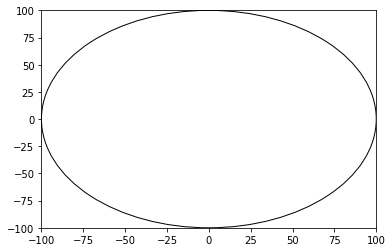

In [246]:
circle = plt.Circle([0,0], radius = 100, fill = False)
fig, ax = plt.subplots()
ax.set_ylim(-100, 100)

ax.set_xlim(-100, 100)
ax.add_artist(circle)
plt.show()

([<matplotlib.axis.XTick at 0x1fc2471af08>,
 <a list of 2 Text xticklabel objects>)

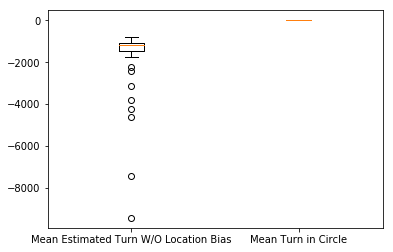

In [292]:
plt.boxplot([mean_turn_circle, mean_estimated_turn])
plt.xticks([1, 2], ['Mean Estimated Turn W/O Location Bias', 'Mean Turn in Circle'])

In [289]:
np.mean(mean_turn_circle)

0.9722541079314685

In [290]:
np.mean(mean_estimated_turn)

0.8325042421548577